In [1]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import SegformerFeatureExtractor
from scipy.ndimage import zoom
import seaborn as sns
import timm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

csv_path = "C:/Users/HP/Downloads/GLEASON/Train_with_Gleason_and_Labels.csv"
df = pd.read_csv(csv_path)
df['image_path'] = df['image_path'].apply(lambda x: os.path.join('C:/Users/HP/Downloads/GLEASON/Train Imgs', os.path.basename(x)))
df['mask_path'] = df['mask_path'].apply(lambda x: os.path.join('C:/Users/HP/Downloads/GLEASON/', x.strip('./')))

def remap_risk_label(label):
    if label in [0, 1]:
        return 0
    elif label == 2:
        return 1
    elif label == 3:
        return 2
    else:
        return -1

df['risk_class'] = df['risk_label'].apply(remap_risk_label)
df = df[df['risk_class'] != -1]

In [3]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['risk_class'], random_state=42)

# === SegFormer Preprocessor Only (already trained) ===
feature_extractor = SegformerFeatureExtractor.from_pretrained("segformer_finetuned")

# === Combined Dataset with 5 Channels ===
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:30: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [4]:
class Prostate5ChannelDataset(Dataset):
    def __init__(self, dataframe, seg_dir, transform):
        self.df = dataframe.reset_index(drop=True)
        self.seg_dir = seg_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB')
        patho_mask = Image.open(row['mask_path']).convert('L')
        seg_mask = Image.open(os.path.join(self.seg_dir, f"mask_{idx:03d}.png")).convert('L')

        image = self.transform(image)
        patho_mask = self.transform(patho_mask)
        seg_mask = self.transform(seg_mask)

        combined = torch.cat([image, patho_mask, seg_mask], dim=0)
        label = torch.tensor(row['risk_class']).long()
        return combined, label

In [5]:
output_dir = "segformer_outputs"
train_dataset = Prostate5ChannelDataset(train_df, output_dir, train_transform)
val_dataset = Prostate5ChannelDataset(val_df, output_dir, val_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# === Model: ResNetv2 50x1 BITM ===
class ResNetv2BITM5Channel(nn.Module):
    def __init__(self, model_name='resnetv2_50x1_bitm', num_classes=3):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True, in_chans=5, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

In [6]:
def evaluate(model, dataloader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            pred = outputs.argmax(1)
            preds.extend(pred.cpu().numpy())
            labels.extend(y.cpu().numpy())
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Moderate", "High"])
    disp.plot(cmap="Blues")
    plt.title("Validation Confusion Matrix")
    plt.show()
    return acc, f1

In [9]:
model = ResNetv2BITM5Channel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
class_counts = torch.tensor([356, 336, 479], dtype=torch.float)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4)
best_f1, patience, wait = 0, 5, 0

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name resnetv2_50x1_bitm to current resnetv2_50x1_bit.goog_in21k_ft_in1k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HP\.cache\huggingface\hub\models--timm--resnetv2_50x1_bit.goog_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████| 59/59 [12:33<00:00, 12.78s/it]


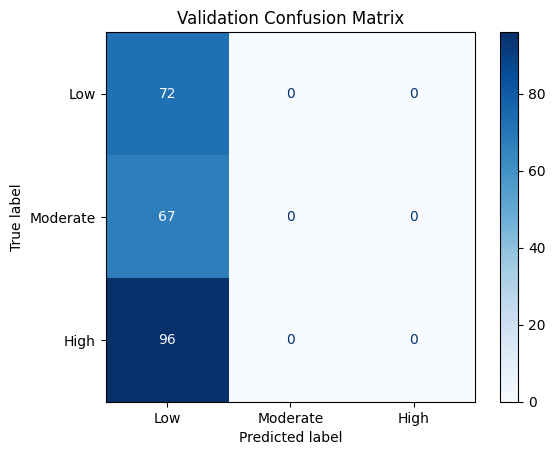

Epoch 1: Loss=84.9751, Acc=0.3064, F1=0.1437
Best model saved.


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████| 59/59 [12:18<00:00, 12.52s/it]


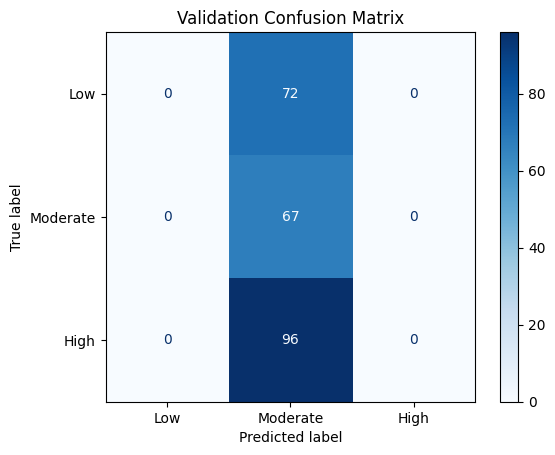

Epoch 2: Loss=67.1691, Acc=0.2851, F1=0.1265


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████| 59/59 [12:08<00:00, 12.35s/it]


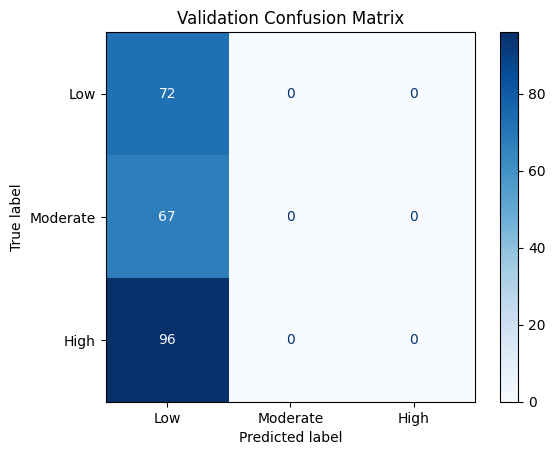

Epoch 3: Loss=66.1279, Acc=0.3064, F1=0.1437


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████| 59/59 [12:19<00:00, 12.53s/it]


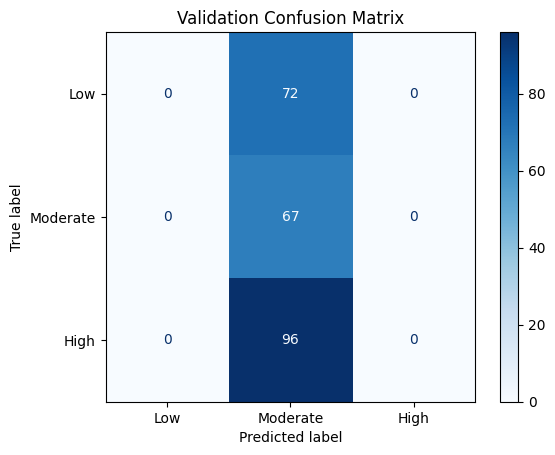

Epoch 4: Loss=65.5823, Acc=0.2851, F1=0.1265


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████| 59/59 [12:18<00:00, 12.51s/it]


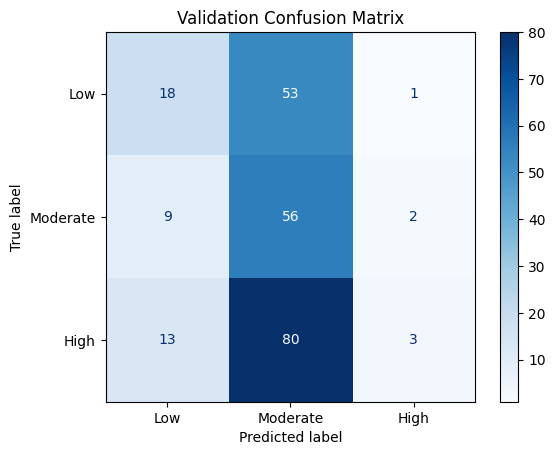

Epoch 5: Loss=64.7478, Acc=0.3277, F1=0.2472
Best model saved.


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████| 59/59 [12:08<00:00, 12.35s/it]


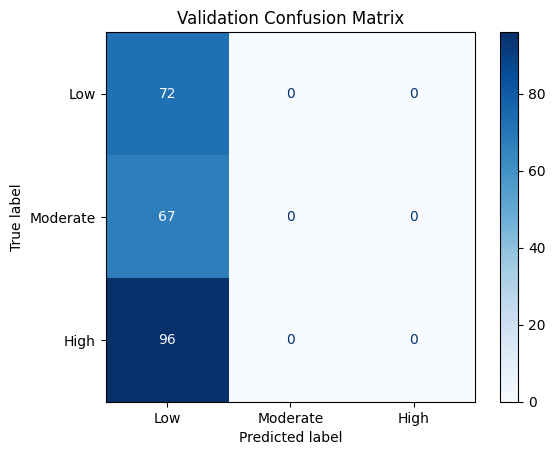

Epoch 6: Loss=64.7505, Acc=0.3064, F1=0.1437


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████| 59/59 [12:35<00:00, 12.81s/it]


KeyboardInterrupt: 

In [10]:
for epoch in range(20):
    model.train()
    running_loss = 0.0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    acc, f1 = evaluate(model, val_loader)
    scheduler.step(f1)
    print(f"Epoch {epoch+1}: Loss={running_loss:.4f}, Acc={acc:.4f}, F1={f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "best_model_resnetv2_50x1_bitm.pt")
        print("Best model saved.")
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break

In [18]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
from torchvision.transforms.functional import to_pil_image

# Set these correctly
output_dir = "segformer_outputs"  # Directory with saved segformer masks
save_dir = "C:/Users/HP/Downloads/Train_Testings"
os.makedirs(save_dir, exist_ok=True)

# Replace val_df and val_dataset_4ch with your actual ones
indices = random.sample(range(len(val_df)), 5)

for i in indices:
    img_tensor, label = val_dataset_4ch[i]
    image_rgb_tensor = img_tensor[:3, :, :]
    pathologist_mask = img_tensor[3, :, :].cpu().numpy()
    segformer_mask_path = os.path.join(output_dir, f"mask_{i:03d}.png")
    segformer_mask = Image.open(segformer_mask_path).resize((224, 224))
    segformer_mask_np = np.array(segformer_mask)

    image_path = val_df.iloc[i]['image_path']
    image_id = os.path.splitext(os.path.basename(image_path))[0]
    image_pil = to_pil_image(image_rgb_tensor)

    # Overlay
    overlay = plt.cm.jet(segformer_mask_np / 255.0)[..., :3]
    overlay = (overlay * 255).astype(np.uint8)
    overlay_pil = Image.fromarray(overlay).resize((224, 224)).convert("RGB")
    overlay_combined = Image.blend(image_pil.convert("RGB"), overlay_pil, alpha=0.5)

    # Plot all 4
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    axs[0].imshow(image_pil)
    axs[0].set_title(f"Original Image\nLabel: {label}")
    axs[0].axis('off')

    axs[1].imshow(pathologist_mask, cmap='gray')
    axs[1].set_title("Pathologist Mask")
    axs[1].axis('off')

    axs[2].imshow(segformer_mask_np, cmap='jet')
    axs[2].set_title("SegFormer Semantic Mask")
    axs[2].axis('off')

    axs[3].imshow(overlay_combined)
    axs[3].set_title("SegFormer Overlay")
    axs[3].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{image_id}_train.png"))
    plt.close()
